In [12]:
from sportsipy.nhl.teams import Teams
from scipy.stats import pearsonr
from scipy.stats import skew,kurtosis
import pandas as pd
from urllib.request import urlopen
from bs4 import BeautifulSoup
import statistics
from matplotlib import pyplot as plt
import collections

In [2]:
# https://towardsdatascience.com/web-scraping-nba-stats-4b4f8c525994
def getGa(abbr,year):
    url = 'https://www.hockey-reference.com/teams/' + abbr + '/' + str(year) + '.html'
    html = urlopen(url)
    soup = BeautifulSoup(html,features="lxml")
    
    # avoid the first header row
    rows = soup.findAll('tr')[1:]
    all_stats = [[td.getText() for td in rows[i].findAll('td')]for i in range(len(rows))]
    all_stats2 = [e for e in all_stats if e]
    all_stats3=[x for x in all_stats2 if len(x)>3]
    team_stats = all_stats3[0]
    if (year >= 2006) or (year == 1999):
        goals_against = team_stats[8]
    elif (year >= 2000) and (year <= 2004):
        goals_against = team_stats[9]
    else:
        goals_against = team_stats[7]
    return(goals_against)

In [2]:
print('Correlation(WinRatio,GoalsForRatio)\n')

maxCorr= -1.1
minCorr= 1.1
minYear = 2021
maxYear = 2021
corrList = []

corrd = {}
for year in range(2006, 2021):
    if year == 2005:
        continue
    teams = list(Teams(year))
    statd = {}
    for i,team in enumerate(teams[0:len(teams)]):
        G = team.games_played
        WinPct = round(100*.5*team.points/G,3)
        GF = team.goals_for
        GA = int(getGa(team.abbreviation,year))
        statd[i] = {'Team' : team.name,
                    'WinPct' : WinPct,
                    'GfrPct' : round(100*GF/(GF+GA),3)} 

    df = pd.DataFrame(statd)
    df = df.transpose()

    corr, _ = pearsonr(df['GfrPct'].tolist(), df['WinPct'].tolist())
    corrList.append(corr)
    
    if maxCorr < minCorr:
        minCorr = corr
        maxCorr = corr
        minYear = year
        maxYear = year
        print('%s: %s (new min) (new max)' % (year,round(corr,3)))
    elif corr < minCorr:
        minCorr= corr
        minYear = year
        print('%s: %s (new min)' % (year,round(corr,3)))
    elif corr > maxCorr:
        maxCorr= corr
        maxYear = year
        print('%s: %s (new max)' % (year,round(corr,3)))
    else: 
        print('%s: %s' % (year,round(corr,3)))

print('MIN:%s (%s)' % (minYear,round(minCorr,3)))
print('MAX:%s (%s)' % (maxYear,round(maxCorr,3)))
print('AVG:%s' % (round(sum(corrList)/len(corrList),3)))

Correlation(WinRatio,GoalsForRatio)

2006: 0.928 (new min) (new max)
2007: 0.943 (new max)
2008: 0.917 (new min)
2009: 0.951 (new max)
2010: 0.946
2011: 0.925
2012: 0.9 (new min)
2013: 0.923
2014: 0.968 (new max)
2015: 0.961
2016: 0.951
2017: 0.974 (new max)
2018: 0.981 (new max)
2019: 0.968
2020: 0.968
MIN:2012 (0.9)
MAX:2018 (0.981)
AVG:0.947


In [ ]:
'''
MIN:2012 (0.9)
MAX:2018 (0.981)
AVG:0.947
'''

In [18]:
year=1945
teams = list(Teams(year))
statd = {}

for i,team in enumerate(teams[0:len(teams)]):
    G = team.games_played
    WinPct = round(100*.5*team.points/G,3)
    GF = team.goals_for
    GA = int(getGa(team.abbreviation,year))
    if year >= 2000:
        T = G-(team.wins+team.losses+team.overtime_losses)
        OTL = team.overtime_losses
    else:
        T = G-(team.wins+team.losses)
        OTL = 0
    statd[i] = {'Team' : team.name,
                'W' : team.wins,
                'T' : T,
                'OTL' : OTL, 
                'L' : team.losses,               
                'G' : G,
                'WinPct' : WinPct,
                'GF' : GF,
                'GA' : GA,
                'GD' : GF-GA,
                'GfrPct' : round(100*GF/(GF+GA),3),
                'GD_per' : round((GF-GA)/G,2)} 
        
df = pd.DataFrame(statd)
df = df.transpose()

l = df[['WinPct','GfrPct']].values.tolist()
seq = sorted(l, key=lambda x: ((-float(x[0])), (-float(x[1]))))
index = [seq.index(v) for v in l]
df['Iwin'] =  index

l = df[['GfrPct','WinPct']].values.tolist()
seq = sorted(l, key=lambda x: ((-float(x[0])), (-float(x[1]))))
index = [seq.index(v) for v in l]
df['Igfp'] =  index

df['Delta'] = df['Igfp']-df['Iwin']
x = list(df['Delta'])
seq = sorted(x,reverse=True)
index = [seq.index(v) for v in x]
df['Idel'] =  index

df = df[['Team','W','T','OTL','L','G','GF','GA','WinPct','GD','GD_per','GfrPct','Iwin','Igfp','Delta','Idel']]
df = df.sort_values(['WinPct'],ascending = (False))
df['WINvs50'] = df['WinPct']-50
df_mdian = df.loc[abs(df['GD']) == min(abs((df['GD'])))]
df_mdian = df_mdian[abs(df_mdian['WINvs50']) == min(abs(df_mdian['WINvs50']))].head(1)
df_lucky = df[df['Delta'] == max(df['Delta'])].head(1)
df_nluck = df[df['Delta'] == min(df['Delta'])].head(1)
print('%s Luckiest,Median,Unluckiest Teams:' % year)
df_ext = pd.concat([df_lucky,pd.concat([df_mdian,df_nluck],sort=False)],sort=False)
print(df_ext.to_string(index=False))

1945 Luckiest,Median,Unluckiest Teams:
                Team   W  T OTL   L   G   GF   GA WinPct   GD GD_per  GfrPct  Iwin  Igfp  Delta  Idel WINvs50
  Montreal Canadiens  38  4   0   8  50  228  121     80  107   2.14   65.33     0     0      0     0      30
 Toronto Maple Leafs  24  4   0  22  50  183  161     52   22   0.44  53.198     2     2      0     0       2
  Montreal Canadiens  38  4   0   8  50  228  121     80  107   2.14   65.33     0     0      0     0      30


In [4]:
'''
2012 Luckiest,Median,Unluckiest Teams: (most anomolous)
               Team   W  T OTL   L   G   GF   GA  WinPct   GD GD_per  GfrPct  Iwin  Igfp  Delta  Idel WINvs50
   Florida Panthers  38  0  18  26  82  197  216  57.317  -19  -0.23    47.7    13    21      8     0   7.317
 Montreal Canadiens  31  0  16  35  82  207  214  47.561   -7  -0.09  49.169    27    14    -13    29  -2.439
 Montreal Canadiens  31  0  16  35  82  207  214  47.561   -7  -0.09  49.169    27    14    -13    29  -2.439

2018 Luckiest,Median,Unluckiest Teams: (most predictable)
                Team   W  T OTL   L   G   GF   GA  WinPct  GD GD_per  GfrPct  Iwin  Igfp  Delta  Idel WINvs50
 Washington Capitals  49  0   7  26  82  256  238  64.024  18   0.22  51.822     5    12      7     0  14.024
     St. Louis Blues  44  0   6  32  82  223  222  57.317   1   0.01  50.112    17    18      1     6   7.317
   Los Angeles Kings  45  0   8  29  82  237  202  59.756  35   0.43  53.986    11     6     -5    28   9.756
'''

'\n2012 Luckiest,Median,Unluckiest Teams: (most anomolous)\n               Team   W  T OTL   L   G   GF   GA  WinPct   GD GD_per  GfrPct  Iwin  Igfp  Delta  Idel WINvs50\n   Florida Panthers  38  0  18  26  82  197  216  57.317  -19  -0.23    47.7    13    21      8     0   7.317\n Montreal Canadiens  31  0  16  35  82  207  214  47.561   -7  -0.09  49.169    27    14    -13    29  -2.439\n Montreal Canadiens  31  0  16  35  82  207  214  47.561   -7  -0.09  49.169    27    14    -13    29  -2.439\n\n2018 Luckiest,Median,Unluckiest Teams: (most predictable)\n                Team   W  T OTL   L   G   GF   GA  WinPct  GD GD_per  GfrPct  Iwin  Igfp  Delta  Idel WINvs50\n Washington Capitals  49  0   7  26  82  256  238  64.024  18   0.22  51.822     5    12      7     0  14.024\n     St. Louis Blues  44  0   6  32  82  223  222  57.317   1   0.01  50.112    17    18      1     6   7.317\n   Los Angeles Kings  45  0   8  29  82  237  202  59.756  35   0.43  53.986    11     6     -5    28 

In [19]:
year=1945
teams = list(Teams(year))
statd = {}

for i,team in enumerate(teams[0:len(teams)]):
    G = team.games_played
    WinPct = round(100*.5*team.points/G,3)
    GF = team.goals_for
    GA = int(getGa(team.abbreviation,year))
    if year >= 2000:
        T = G-(team.wins+team.losses+team.overtime_losses)
        OTL = team.overtime_losses
    else:
        T = G-(team.wins+team.losses)
        OTL = 0
    statd[i] = {'Team' : team.name,
                'W' : team.wins,
                'T' : T,
                'OTL' : OTL, 
                'L' : team.losses,               
                'G' : G,
                'WinPct' : WinPct,
                'GF' : GF,
                'GA' : GA,
                'GfrPct' : round(100*GF/(GF+GA),3),
                'GD_per' : round((GF-GA)/G,2)} 
        
df = pd.DataFrame(statd)
df = df.transpose()

l = df[['WinPct','GfrPct']].values.tolist()
seq = sorted(l, key=lambda x: ((-float(x[0])), (-float(x[1]))))
index = [seq.index(v) for v in l]
df['Iwin'] =  index

l = df[['GfrPct','WinPct']].values.tolist()
seq = sorted(l, key=lambda x: ((-float(x[0])), (-float(x[1]))))
index = [seq.index(v) for v in l]
df['Igfp'] =  index

df['Delta'] = df['Igfp']-df['Iwin']
x = list(df['Delta'])
seq = sorted(x,reverse=True)
index = [seq.index(v) for v in x]
df['Idel'] =  index

df = df[['Team','W','T','OTL','L','G','GF','GA','WinPct','GD_per','GfrPct','Iwin','Igfp','Delta','Idel']]
df = df.sort_values(['WinPct'],ascending = (False))
print('%s NHL Season - Ranked by %% Games Won [>LosPct]' % year)
with pd.option_context('display.max_rows',6):
    display(df)

df = df.sort_values('GfrPct',ascending=False)
print('\n%s NHL Season - Ranked by %% Points Scored [<GfrPct]' % year)
with pd.option_context('display.max_rows',6):
    display(df)

df = df.sort_values('Idel',ascending=True)
print('\n%s NHL Season - Ranked by Luck [<Delta (Igfp-Iwin)]' % year)
with pd.option_context('display.max_rows',6):
    display(df)

1945 NHL Season - Ranked by % Games Won [>LosPct]


,Team,W,T,OTL,L,G,GF,GA,WinPct,GD_per,GfrPct,Iwin,Igfp,Delta,Idel
0,Montreal Canadiens,38,4,0,8,50,228,121,80,2.14,65.33,0,0,0,0
1,Detroit Red Wings,31,5,0,14,50,218,161,67,1.14,57.52,1,1,0,0
2,Toronto Maple Leafs,24,4,0,22,50,183,161,52,0.44,53.198,2,2,0,0
3,Boston Bruins,16,4,0,30,50,179,219,36,-0.8,44.975,3,3,0,0
4,Chicago Black Hawks,13,7,0,30,50,141,194,33,-1.06,42.09,4,4,0,0
5,New York Rangers,11,10,0,29,50,154,247,32,-1.86,38.404,5,5,0,0



1945 NHL Season - Ranked by % Points Scored [<GfrPct]


,Team,W,T,OTL,L,G,GF,GA,WinPct,GD_per,GfrPct,Iwin,Igfp,Delta,Idel
0,Montreal Canadiens,38,4,0,8,50,228,121,80,2.14,65.33,0,0,0,0
1,Detroit Red Wings,31,5,0,14,50,218,161,67,1.14,57.52,1,1,0,0
2,Toronto Maple Leafs,24,4,0,22,50,183,161,52,0.44,53.198,2,2,0,0
3,Boston Bruins,16,4,0,30,50,179,219,36,-0.8,44.975,3,3,0,0
4,Chicago Black Hawks,13,7,0,30,50,141,194,33,-1.06,42.09,4,4,0,0
5,New York Rangers,11,10,0,29,50,154,247,32,-1.86,38.404,5,5,0,0



1945 NHL Season - Ranked by Luck [<Delta (Igfp-Iwin)]


,Team,W,T,OTL,L,G,GF,GA,WinPct,GD_per,GfrPct,Iwin,Igfp,Delta,Idel
0,Montreal Canadiens,38,4,0,8,50,228,121,80,2.14,65.33,0,0,0,0
1,Detroit Red Wings,31,5,0,14,50,218,161,67,1.14,57.52,1,1,0,0
2,Toronto Maple Leafs,24,4,0,22,50,183,161,52,0.44,53.198,2,2,0,0
3,Boston Bruins,16,4,0,30,50,179,219,36,-0.8,44.975,3,3,0,0
4,Chicago Black Hawks,13,7,0,30,50,141,194,33,-1.06,42.09,4,4,0,0
5,New York Rangers,11,10,0,29,50,154,247,32,-1.86,38.404,5,5,0,0


In [6]:
minDelta = 0
maxDelta = 0
deltaList = []
for year in range(1970, 2021):
    if year == 2005:
        continue
    teams = list(Teams(year))
    statd = {}
    for i,team in enumerate(teams[0:len(teams)]):
        G = team.games_played
        WinPct = round(100*.5*team.points/G,3)
        GF = team.goals_for
        GA = int(getGa(team.abbreviation,year))
        statd[i] = {'Team' : team.name,
                    'WinPct' : WinPct,
                    'GfrPct' : round(100*GF/(GF+GA),3)}
        
    df = pd.DataFrame(statd)
    df = df.transpose()

    l = df[['WinPct','GfrPct']].values.tolist()
    seq = sorted(l, key=lambda x: ((-float(x[0])), (-float(x[1]))))
    index = [seq.index(v) for v in l]
    df['Iwin'] =  index

    l = df[['GfrPct','WinPct']].values.tolist()
    seq = sorted(l, key=lambda x: ((-float(x[0])), (-float(x[1]))))
    index = [seq.index(v) for v in l]
    df['Igfp'] =  index


    df['Delta'] = df['Igfp']-df['Iwin']
    x = list(df['Delta'])
    
    locMinDelta = int(min(df['Delta']))
    locMinTeam = df.Team[df['Delta'] == locMinDelta]
    locMinTeam = locMinTeam.to_string(index=False)
    locMaxDelta = int(max(df['Delta']))
    locMaxTeam = df.Team[df['Delta'] == locMaxDelta]
    locMaxTeam = locMaxTeam.to_string(index=False)
    
    if maxDelta == minDelta:
        minDelta = locMinDelta
        maxDelta = locMaxDelta
        minTeam = locMinTeam
        maxTeam = locMaxTeam
        minYear = year
        maxYear = year
        print('%s %s: %s (new minDelta) (new maxDelta)' % (year,locMinTeam,round(minDelta,3)))
    if locMinDelta < minDelta:
        minDelta= locMinDelta
        minTeam = locMinTeam
        minYear = year
        print('%s %s: %s (new min)' % (year,locMinTeam,round(minDelta,3)))
    if locMaxDelta > maxDelta:
        maxDelta = locMaxDelta
        maxTeam = locMaxTeam
        maxYear = year
        print('%s %s: %s (new max)' % (year,locMaxTeam,round(maxDelta,3)))
    
    for d in x:
        deltaList.append(d)

deltaList=sorted(deltaList,reverse=False)

1970     New York Rangers
     St. Louis Blues
 Philadelphia Flyers: -2 (new minDelta) (new maxDelta)
1971  Pittsburgh Penguins: -4 (new min)
1974  Detroit Red Wings: 3 (new max)
1976  Los Angeles Kings: 4 (new max)
1985  Winnipeg Jets: 5 (new max)
1986  Chicago Black Hawks: 6 (new max)
1994  Buffalo Sabres: -6 (new min)
1994  Pittsburgh Penguins: 10 (new max)
2002  Vancouver Canucks: -7 (new min)
2006  Minnesota Wild: -10 (new min)
2011  New York Rangers: -12 (new min)
2012  Montreal Canadiens: -13 (new min)
2015  Anaheim Ducks: 14 (new max)


In [15]:
print('max: ' + str(max(deltaList)))
print('min: ' + str(min(deltaList)))
print('median: ' + str(statistics.median(deltaList)))
print('mean: ' + str(round(statistics.mean(deltaList),2)))
print('mode: ' + str(statistics.mode(deltaList)))
print('pstdev: ' + str(round(statistics.pstdev(deltaList),2)))
print('pvariance: ' + str(round(statistics.pvariance(deltaList),2)))
print('skew: ' + str(round(skew(deltaList,bias=False),2)))
print('kurtosis-3: ' + str(round(kurtosis(deltaList,bias=False)-3,2)))

quartiles=[round(q, 2) for q in statistics.quantiles(deltaList, n=4)]
print('quartiles(excl): '+ str(quartiles))
deciles=[round(q, 2) for q in statistics.quantiles(deltaList, n=10)]
print('deciles(excl): '+ str(deciles))
print('count: ' + str(len(deltaList)))

max: 14
min: -13
median: 0
mean: 0
mode: 0
pstdev: 2.43
pvariance: 5.92
skew: -0.07
kurtosis-3: 1.01
quartiles(excl): [-1.0, 0.0, 1.0]
deciles(excl): [-3.0, -1.0, -1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 3.0]
count: 1217


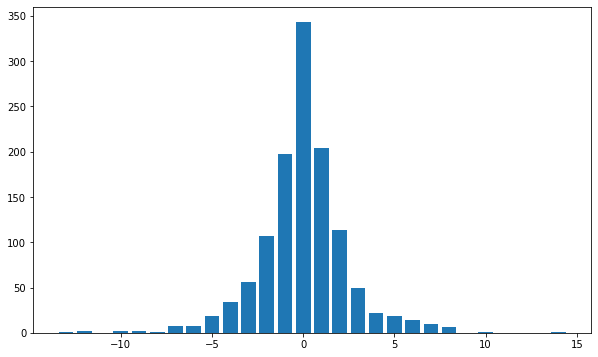

In [8]:
counter=collections.Counter(deltaList)
dely = list(counter.values())
delx = list(counter.keys())
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(delx,dely)
plt.show()

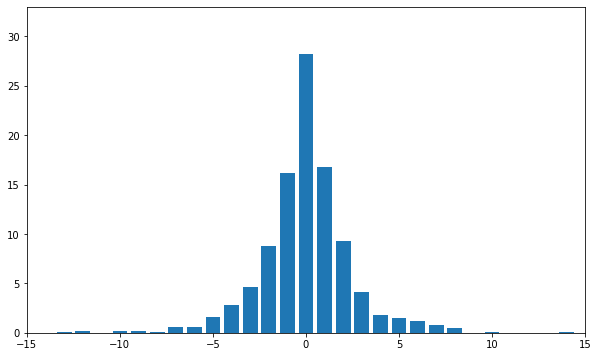

In [27]:
df_freq=pd.DataFrame(list(zip(delx,dely)),columns=['delta','freq'])
df_freq['pct'] = round(100.0*df_freq['freq']/sum(list(df_freq['freq'])),2)
delp = list(df_freq['pct'])
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(delx,delp)
plt.xlim([-15, 15])
plt.ylim([0, 33])
plt.show()

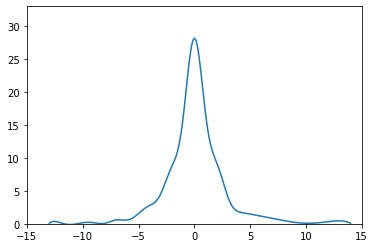

In [28]:
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

#define x as 200 equally spaced values between the min and max of original x 
xnew = np.linspace(min(delx), max(delx), 200) 

#define spline
spl = make_interp_spline(delx, delp, k=5)
y_smooth = spl(xnew)

#create smooth line chart 
plt.plot(xnew, y_smooth)
plt.xlim([-15, 15])
plt.ylim([0, 33])
plt.show()

In [24]:
pd.DataFrame(list(zip(delx,dely,delp)),columns=['delta','freq','pct'])

,delta,freq,pct
0,-13,1,0.08
1,-12,2,0.16
2,-10,2,0.16
3,-9,2,0.16
4,-8,1,0.08
5,-7,7,0.58
6,-6,7,0.58
7,-5,19,1.56
8,-4,34,2.79
9,-3,56,4.60
